# GitHub Setup & Data Import

In [82]:
!git clone https://github.com/vpaulino26/fish-predict

Cloning into 'fish-predict'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 53 (delta 17), reused 18 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 24.52 MiB | 16.26 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [83]:
%cd fish-predict
%cd datasets
!unzip 22560_NEFSCFallFisheriesIndependentBottomTrawlData.zip

/content/fish-predict/datasets/fish-predict/datasets/fish-predict
/content/fish-predict/datasets/fish-predict/datasets/fish-predict/datasets
Archive:  22560_NEFSCFallFisheriesIndependentBottomTrawlData.zip
  inflating: 22560_SVDBS_CRUISES.csv  
  inflating: 22560_UNION_FSCS_SVBIO.csv  
  inflating: 22560_UNION_FSCS_SVCAT.csv  
  inflating: 22560_UNION_FSCS_SVLEN.csv  
  inflating: 22560_UNION_FSCS_SVSTA.csv  


In [84]:
import pandas as pd
import numpy as np
from numpy import shape
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Part 1: Data Set Up & Cleaning

This section focuses on preparing the raw data for analysis and model training. The key steps involve:

1.  **Loading Data:** Importing the `22560_UNION_FSCS_SVCAT.csv` and `22560_UNION_FSCS_SVSTA.csv` files into pandas DataFrames.
2.  **Filtering Data:** Reducing the `svc_cat_df` to include only the top 10 most commercially caught species in Rhode Island, as listed below.
3.  **Dropping Irrelevant Columns:** Removing columns from both DataFrames that are not necessary for the analysis or model building.
4.  **Missing Data Adjustments:** Remove columns where more than half of the entries have a null value since they won't make good predictors.
5.  **Merging DataFrames:** Combining the filtered species data with the station data based on common identifiers to create a unified dataset for subsequent steps.
6. **Reduce Latitude/Longitude:** Set the bounds of latitude and longitude to Rhode Island waters so we don't have other locations changing our predictions.

These are the top 10 commercial species in RI we want to focus on:
1. LONGFIN SQUID
2. SEA SCALLOP
3. AMERICAN LOBSTER
4. SHORTFIN SQUID (ILLEX)
5. SUMMER FLOUNDER
6. QUAHOG
7. SCUP
8. JONAH CRAB
9. BUTTERFISH
10. SILVER HAKE

Note: The species "SHORTFIN SQUID (ILLEX)" is referred to as "NORTHERN SHORTFIN SQUID" in the dataset.

### 1.1 Loading Data

In [85]:
# Import the two data sets and save them as DFs
svcat_df = pd.read_csv('22560_UNION_FSCS_SVCAT.csv', dtype={'CRUISE STRATUM': str, 'STATUS_CODE': str, 'CATCH_COMMENT': str}, low_memory=False)
svsta_df = pd.read_csv('22560_UNION_FSCS_SVSTA.csv', encoding='latin-1', low_memory=False)

print(f"SVCAT:{shape(svcat_df)} \nSVSTA:{shape(svsta_df)}\n")

display(svcat_df.head())
print("\n")
display(svsta_df.head())

SVCAT:(338180, 13) 
SVSTA:(21823, 94)



,CRUISE6,CRUISE,STRATUM,TOW,STATION,STATUS_CODE,ID,SVSPP,CATCHSEX,EXPCATCHNUM,EXPCATCHWT,SCIENTIFIC_NAME,CATCH_COMMENT
0,196307,6307,01260,1,1,10,196307012600010001,15,0,10.0,19.5,Squalus acanthias (spiny dogfish),
1,196307,6307,01260,1,1,10,196307012600010001,23,0,53.0,142.0,Leucoraja ocellata (winter skate),
2,196307,6307,01260,1,1,10,196307012600010001,26,0,11.0,7.7,Leucoraja erinacea (little skate),
3,196307,6307,01260,1,1,10,196307012600010001,31,0,1.0,0.0,Etrumeus teres (round herring),
4,196307,6307,01260,1,1,10,196307012600010001,33,0,2.0,0.5,Alosa pseudoharengus (alewife),


,CRUISE6,CRUISE,STRATUM,TOW,STATION,STATUS_CODE,ID,STATYPE,HAUL,GEARCOND,...,SURFTEMP,SURFSALIN,BOTTEMP,BOTSALIN,FULD,NO_DETAIL_SVSPP,BOTSPEED,WATCH_CHIEF_COMMENTS,STATION_COMMENTS,HABITAT_COMMENTS
0,196307,6307,01260,1,1,10,196307012600010001,1.0,2.0,3.0,...,11.0,NaN,10.1,NaN,NaN,NaN,0.0,,,
1,196307,6307,01260,2,2,10,196307012600020002,1.0,3.0,5.0,...,9.9,NaN,9.9,NaN,NaN,NaN,0.0,,,
2,196307,6307,01260,3,3,10,196307012600030003,1.0,2.0,3.0,...,9.9,NaN,8.1,NaN,NaN,NaN,0.0,,,
3,196307,6307,01260,4,4,10,196307012600040004,1.0,3.0,5.0,...,10.2,NaN,10.1,NaN,NaN,NaN,0.0,,,
4,196307,6307,01260,5,5,10,196307012600050005,1.0,2.0,3.0,...,10.0,NaN,9.4,NaN,NaN,NaN,0.0,,,


### 1.2 Filtering Data

In [86]:
# Filter out non top species
top_species = ['LONGFIN SQUID', 'SEA SCALLOP', 'AMERICAN LOBSTER', 'SHORTFIN SQUID', 'SUMMER FLOUNDER', 'QUAHOG', 'SCUP', 'JONAH CRAB', 'BUTTERFISH', 'SILVER HAKE']

# Filter only rows where the Species column contains any of these names
filtered_svcat = svcat_df[svcat_df["SCIENTIFIC_NAME"].apply(
    lambda x: any(SCIENTIFIC_NAME.lower() in str(x).lower() for SCIENTIFIC_NAME in top_species)
)]

# Compare the unfiltered and filtered dataframes to see that filtering was succesful
print(f"Unfiltered SVCAT:{shape(svcat_df)} \nFiltered SVCAT:{shape(filtered_svcat)}")

Unfiltered SVCAT:(338180, 13) 
Filtered SVCAT:(77275, 13)


### 1.3 Column Adjustments
- We will likely drop more columns from SVSTA as we discover which columns have the most entropy and aren't useful in the model in order to save on training time and complexity.

In [87]:
# Drop columns we won't use from SVCAT
filtered_svcat = filtered_svcat.drop(columns=['CATCHSEX', 'CATCH_COMMENT'])

# Drop columns we won't use from SVSTA
columns_to_drop_sv_sta = [
    'TYPE_CODE', 'TYPE_COMMENT', 'OPERATION_CODE', 'OPERATION_COMMENT',
    'GEAR_CODE', 'GEAR_COMMENT', 'ACQUISITION_CODE', 'ACQUISITION_COMMENT',
    'OTHGEAR', 'WATCH_CHIEF_COMMENTS', 'STATION_COMMENTS', 'HABITAT_COMMENTS'
]
filtered_svsta = svsta_df.drop(columns=columns_to_drop_sv_sta)

# Compare the unfiltered and filtered dataframes to see that filtering was succesful
print(f"Updated SVCAT:{shape(filtered_svcat)} \nUpdated SVSTA:{shape(filtered_svsta)}")

Updated SVCAT:(77275, 11) 
Updated SVSTA:(21823, 82)


### 1.4 Adjusting Missing Values
- Remove the columns where more than 50% of the entires don't have a value
  - 50% is a threshold, we can adjust the amount if we need to
  - SVCAT has no columns that meet this criteria

In [88]:
# Check for missing values in filtered_svcat
print("Missing values in filtered_svcat (over 50% missing):")
missing_svcat = filtered_svcat.isnull().sum() / len(filtered_svcat) * 100
if missing_svcat[missing_svcat > 50].empty:
  print("No columns with over 50% missing values in filtered_svcat")
else:
  display(missing_svcat[missing_svcat > 50])

print("\nMissing values in filtered_svsta (over 50% missing):")
# Check for missing values in filtered_svsta
missing_svsta = filtered_svsta.isnull().sum() / len(filtered_svsta) * 100
display(missing_svsta[missing_svsta > 50])

# Drop the columns that are in missing_svsta
cols_to_drop = missing_svsta[missing_svsta > 50].index.tolist()
filtered_svsta = filtered_svsta.drop(columns=cols_to_drop)
print(f"\nUpdated SVSTA shape after dropping columns with over 50% missing values: {shape(filtered_svsta)}")

Missing values in filtered_svcat (over 50% missing):
No columns with over 50% missing values in filtered_svcat

Missing values in filtered_svsta (over 50% missing):


,0
TOGA,73.463777
BEGEKVLOG,96.879439
ENDEKVLOG,96.879439
ENDLAT,54.140127
ENDLON,54.140127
DECDEG_ENDLAT,54.140127
DECDEG_ENDLON,54.140127
PITCH,53.365715
RPM,52.009348
DOPDISTW,76.891353



Updated SVSTA shape after dropping columns with over 50% missing values: (21823, 62)


### 1.5 Merging DataFrames
- Merge the DataFrames together on ID so that all the information is in one DF
- The columns that appear in both datasets always have identical data, so we can only keep the columns from one and avoid dealing with duplicates

In [89]:
# Merge the dataframes on 'ID'
merged_df = pd.merge(filtered_svcat, filtered_svsta, on='ID', suffixes=('_cat', '_sta'))

# Drop duplicate columns, keeping the ones from filtered_svcat (those without '_sta' suffix)
columns_to_drop = [col for col in merged_df.columns if col.endswith('_sta')]
merged_df = merged_df.drop(columns=columns_to_drop)

# Rename the _cat columns to remove suffix
merged_df.columns = merged_df.columns.str.replace('_cat', '')

# Display the merged dataframe
print(f"Merged dataframe shape: {shape(merged_df)}")
display(merged_df.head())

Merged dataframe shape: (77275, 66)


,CRUISE6,CRUISE,STRATUM,TOW,STATION,STATUS_CODE,ID,SVSPP,EXPCATCHNUM,EXPCATCHWT,...,BAROPRESS,WINDDIR,WINDSP,WAVEHGT,SWELLDIR,SWELLHGT,XBT,SURFTEMP,BOTTEMP,BOTSPEED
0,196307,6307,01260,1,1,10,196307012600010001,72,52.0,9.5,...,1012.0,250.0,6.0,0.0,NaN,NaN,3,11.0,10.1,0.0
1,196307,6307,01260,2,2,10,196307012600020002,72,35.0,18.1,...,1012.0,230.0,8.0,0.0,NaN,NaN,3,9.9,9.9,0.0
2,196307,6307,01260,3,3,10,196307012600030003,72,164.0,10.4,...,1012.0,200.0,6.0,0.0,NaN,NaN,3,9.9,8.1,0.0
3,196307,6307,01260,3,3,10,196307012600030003,503,7.0,0.0,...,1012.0,200.0,6.0,0.0,NaN,NaN,3,9.9,8.1,0.0
4,196307,6307,01260,4,4,10,196307012600040004,72,7.0,3.2,...,1012.0,220.0,6.0,0.0,NaN,NaN,3,10.2,10.1,0.0


### 1.6 Set Latitude/Longitude Bounds
* The dataset ranges from NY to Canada, so we want to limit the range to Rhode Island's latitude and longitude

In [90]:
# Define approximate bounds for Rhode Island waters
lat_min = 41.0
lat_max = 42.0
lon_min = -72.0
lon_max = -70.5

# Filter the merged dataframe
ri_filtered_df = merged_df[
    (merged_df['DECDEG_BEGLAT'] >= lat_min) & (merged_df['DECDEG_BEGLAT'] <= lat_max) &
    (merged_df['DECDEG_BEGLON'] >= lon_min) & (merged_df['DECDEG_BEGLON'] <= lon_max)
]

print(f"Shape of the dataframe after filtering for Rhode Island waters: {shape(ri_filtered_df)}")

Shape of the dataframe after filtering for Rhode Island waters: (2330, 66)


# Part 2: Exploratory Analysis

This section focuses on exploring the filtered data for Rhode Island waters to understand the distributions of key variables and relationships between them. The key steps involve:

1.  **Visualize distributions:** Create visualizations to show the distributions of catch weight, temperature, and depth.
2.  **Visualize species abundance:** Create visualizations to show species abundance over time or by region (e.g., using scatter plots or heatmaps on a map).
3.  **Plot correlations:** Generate plots to visualize the correlations between environmental variables (temperature, salinity, depth) and catch weight.
4. **Summarize Findings & Insights:** Based on these visualizations, analyze and make hypotheses on how the model may work and come up with steps for feature engineering.

### 2.1 Visualizing Distributions
* The distribution of catch weight is heavily skewed towards lower values, indicating that most hauls have small catches, with a few large catches.
* The distribution of surface temperature appears to be slightly skewed, leaning towards the slightly warmer tempratures.
* The distribution of average depth is also slightly skewed towards shallower depths, suggesting that most fishing activity in Rhode Island waters occurs in relatively shallow areas.

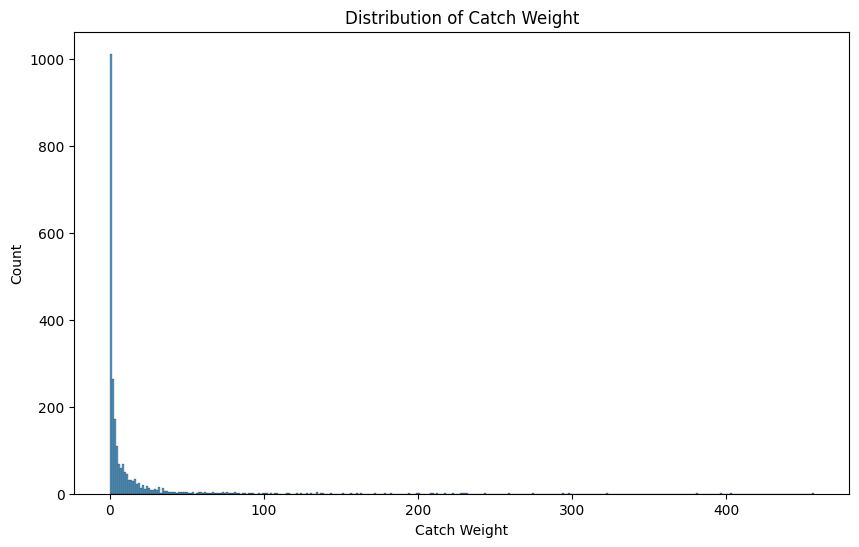

In [91]:
# Create a histogram for Catch Weight
plt.figure(figsize=(10, 6))
sns.histplot(data=ri_filtered_df, x='EXPCATCHWT')
plt.xlabel('Catch Weight')
plt.title('Distribution of Catch Weight')
plt.show()

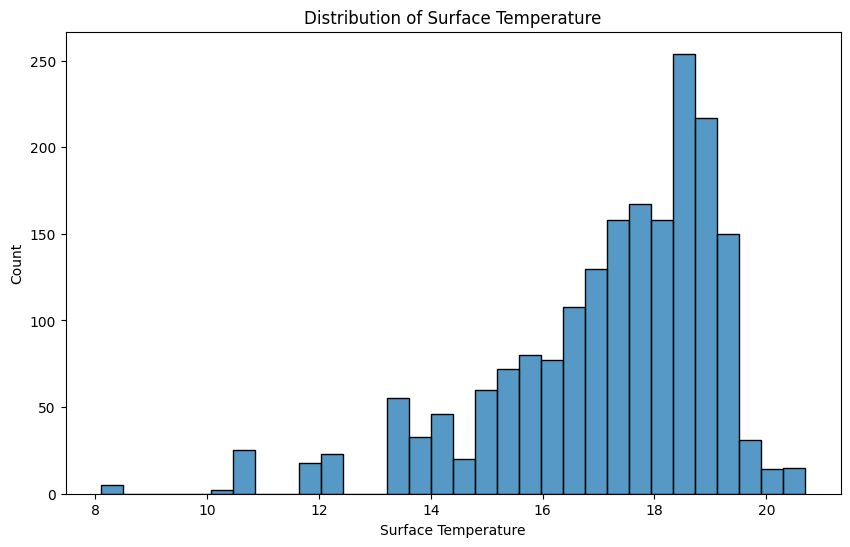

In [92]:
# Create a histogram for Surface Temperature
plt.figure(figsize=(10, 6))
sns.histplot(data=ri_filtered_df, x='SURFTEMP')
plt.xlabel('Surface Temperature')
plt.title('Distribution of Surface Temperature')
plt.show()

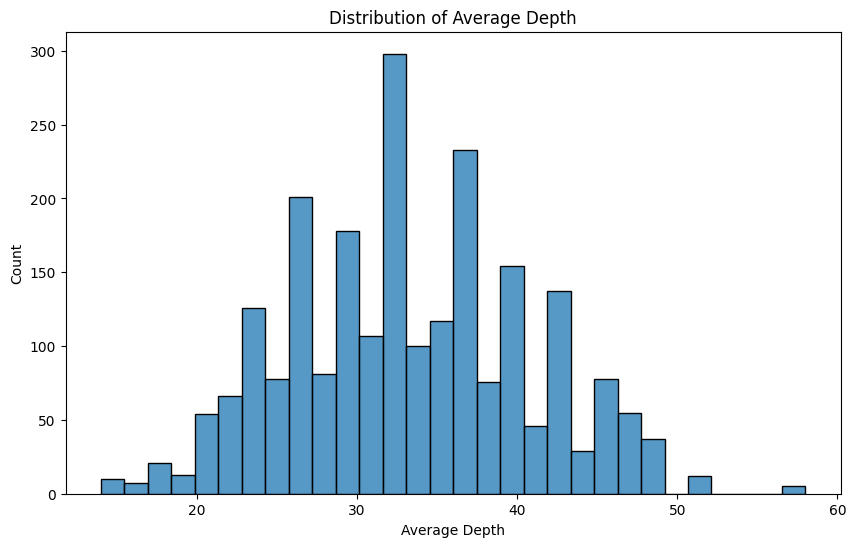

In [93]:
# Create a histogram for Average Depth
plt.figure(figsize=(10, 6))
sns.histplot(data=ri_filtered_df, x='AVGDEPTH')
plt.xlabel('Average Depth')
plt.title('Distribution of Average Depth')
plt.show()

### 2.2 Visualizing Species Abundance
* The species abundance over time shows fluctuations for different species, with some species showing increasing trends in catch weight over the years and others decreasing or remaining relatively stable.
* The scatter plot of species abundance by region shows that different species are concentrated in different areas within Rhode Island waters, suggesting some spatial segregation based on species.
* Based on the line plot, the three most abundant species in recent years appear to be SCUP, SILVER HAKE, and BUTTERFISH.

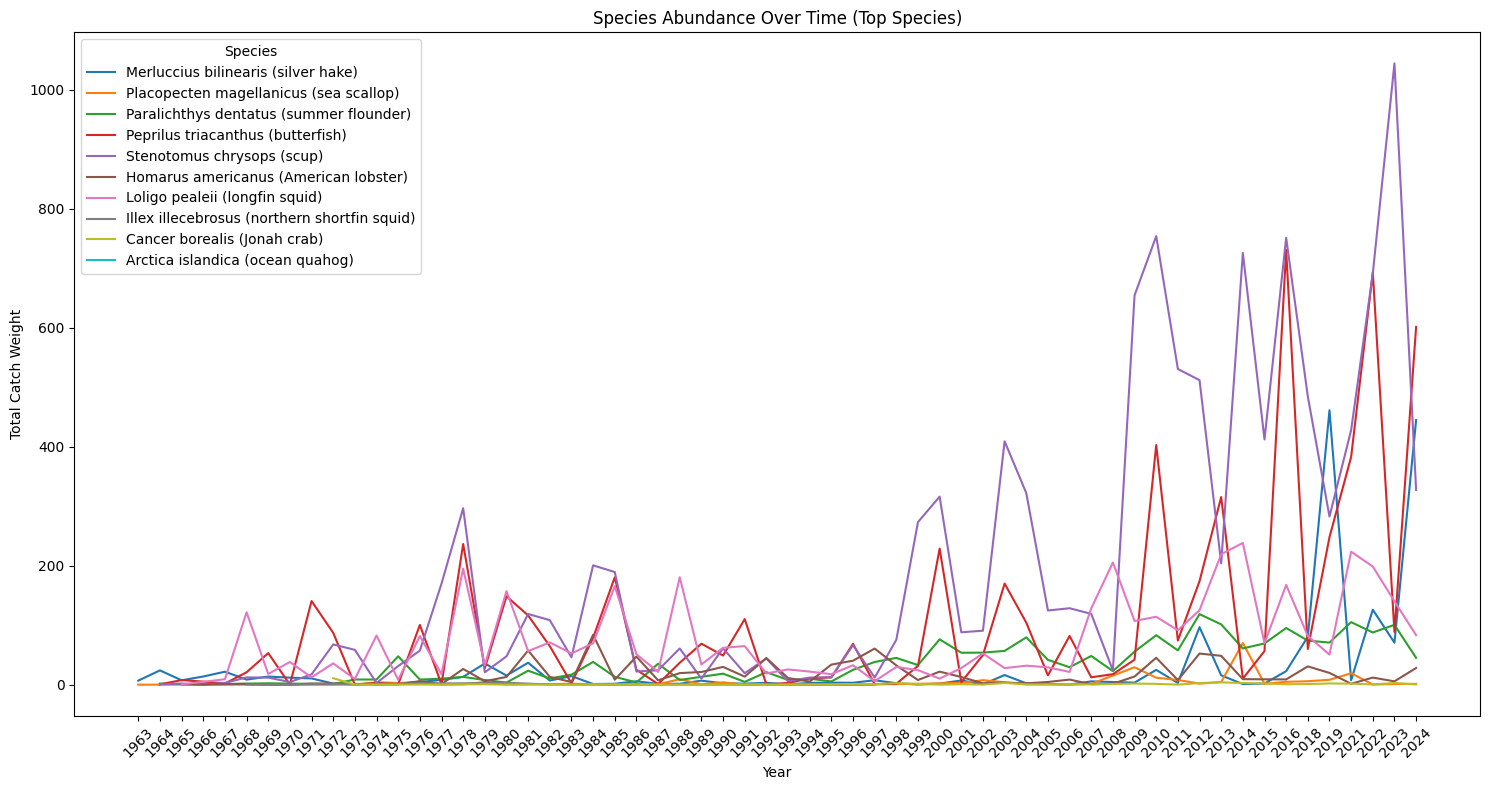

In [94]:
# Extract the year from the 'CRUISE6' column
ri_copy = ri_filtered_df.copy()
ri_copy['YEAR'] = ri_copy['CRUISE6'].astype(str).str[:4]

# Group by year and scientific name and sum the catch weight
species_abundance_time = ri_copy.groupby(['YEAR', 'SCIENTIFIC_NAME'])['EXPCATCHWT'].sum().reset_index()

# Filter the grouped data to include only the top species
species_abundance_time_top = species_abundance_time[species_abundance_time['SCIENTIFIC_NAME'].apply(
    lambda x: any(spec.lower() in str(x).lower() for spec in top_species)
)]

# Plot the species abundance over time for the top species
plt.figure(figsize=(15, 8))
sns.lineplot(data=species_abundance_time_top, x='YEAR', y='EXPCATCHWT', hue='SCIENTIFIC_NAME')
plt.xlabel('Year')
plt.ylabel('Total Catch Weight')
plt.title('Species Abundance Over Time (Top Species)')
plt.xticks(rotation=45)
plt.legend(title='Species')
plt.tight_layout()
plt.show()

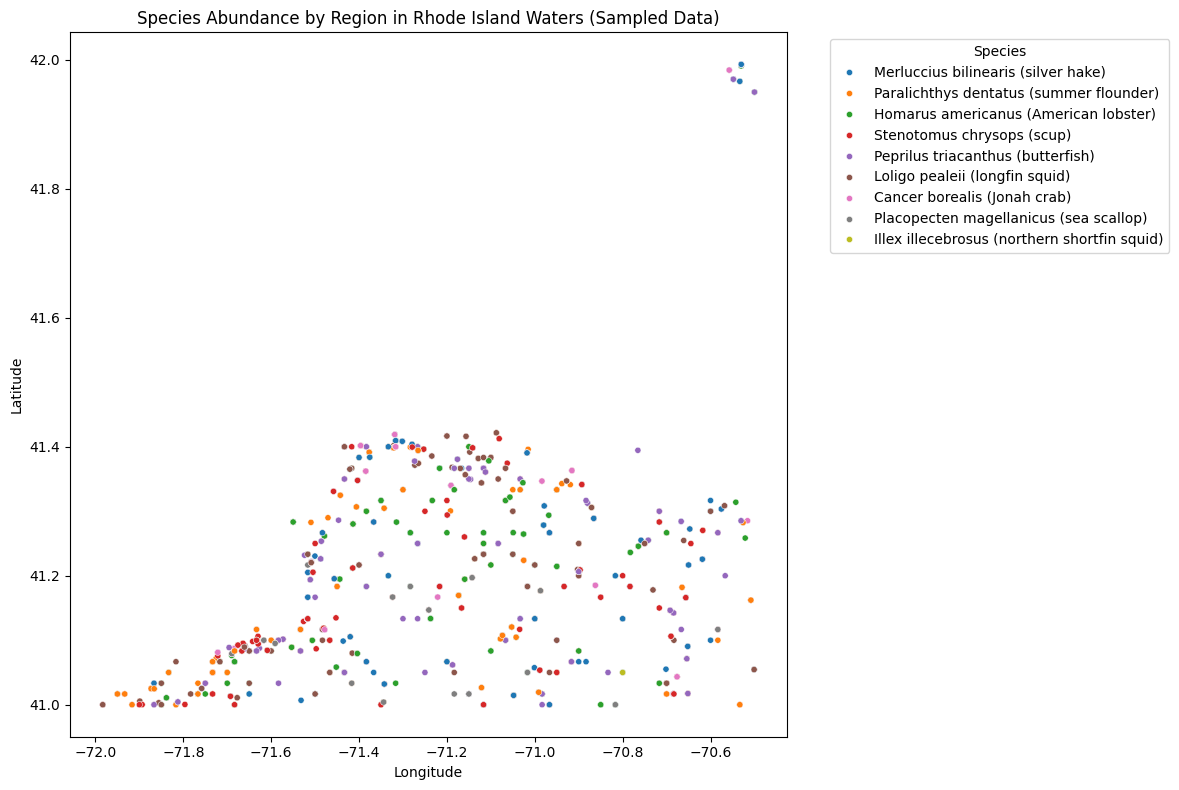

In [95]:
# Visualize species abundance by region using a scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=ri_copy.sample(n=1000, random_state=42), x='DECDEG_BEGLON', y='DECDEG_BEGLAT', hue='SCIENTIFIC_NAME', s=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Species Abundance by Region in Rhode Island Waters (Sampled Data)')
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 2.3 Plotting Correlations
* There is no clear linear relationship between Catch Weight and Average Depth.
* There is no clear linear relationship between Catch Weight and Surface Temperature.

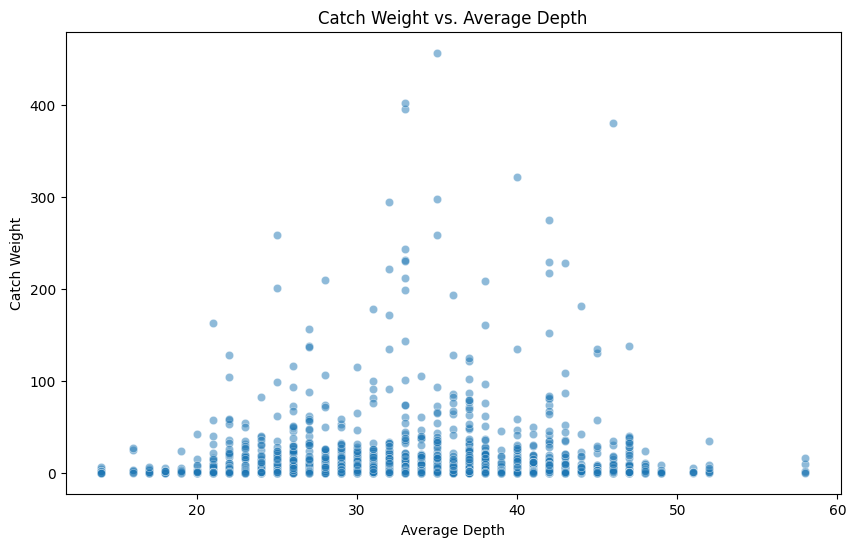

In [96]:
# Create scatter plot for Catch Weight vs. Average Depth
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ri_filtered_df, x='AVGDEPTH', y='EXPCATCHWT', alpha=0.5)
plt.xlabel('Average Depth')
plt.ylabel('Catch Weight')
plt.title('Catch Weight vs. Average Depth')
plt.show()

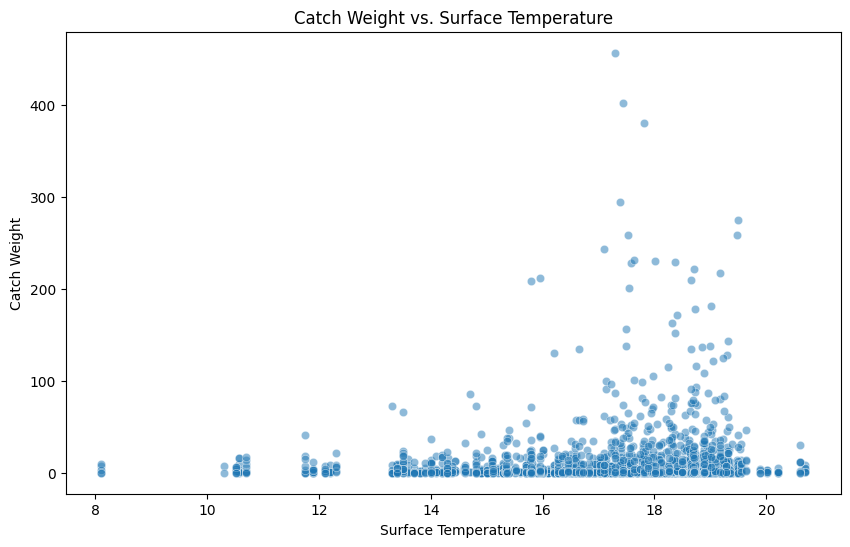

In [97]:
# Create scatter plot for Catch Weight vs. Surface Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ri_filtered_df, x='SURFTEMP', y='EXPCATCHWT', alpha=0.5)
plt.xlabel('Surface Temperature')
plt.ylabel('Catch Weight')
plt.title('Catch Weight vs. Surface Temperature')
plt.show()

### 2.4 Summarize Findings & Insights

Based on the visualizations in the previous sections, here are our key findings and insights:

*   The distribution of catch weight is highly skewed, suggesting that a model might need to account for this skewness or that the target variable could be transformed (e.g., using a logarithmic transformation).
*   There doesn't appear to be strong linear correlations between catch weight and environmental factors like depth and surface temperature. However, this doesn't rule out non-linear relationships or interactions between variables.
*   Species abundance varies significantly over time and across different locations within Rhode Island waters. This indicates that both temporal and spatial features could be important predictors in a model.
*   The identification of the most abundant species in recent years suggests that focusing on these species or including species as a categorical feature in the model could be beneficial.

Potential steps for feature engineering could include:

*   Creating temporal features such as month, season, or year.
*   Considering transformations of the target variable (catch weight) to address the skewed distribution.

# Part 3: Feature Engineering

This section focuses on preparing the data for model training by creating new features and transforming existing ones. The key steps involve:

1.  **Create Derived Variables:** Generate new features from existing columns, such as year, month, and average temperature.
2.  **Encode Categorical Variables:** Convert categorical features like species name into a format suitable for the model using techniques like one-hot encoding.
3.  **Normalize or Scale Numeric Features:** Scale numerical features to ensure they have similar ranges, preventing features with larger values from dominating the model.
4. **Target Transformation:** Apply a transformation to the target variable (catch weight) to address its skewed distribution, potentially improving model performance.

### 3.1 Create Derived Variables

* Based on the exploratory analysis, we will create the following derived variables:
  *   **Year:** Extract the year from the `CRUISE6` column.
  *   **Month:** Extract the month from the `CRUISE6` column.
  *   **Average Temperature:** Create an average temperature from surface and bottom temperatures if both are available.

In [98]:
# Extract year and month from CRUISE6
ri_filtered_df = ri_filtered_df.copy()
ri_filtered_df['YEAR'] = ri_filtered_df['CRUISE6'].astype(str).str[:4]
ri_filtered_df['MONTH'] = ri_filtered_df['CRUISE6'].astype(str).str[4:6]

# Convert Year and Month to numerical values
ri_filtered_df['YEAR'] = pd.to_numeric(ri_filtered_df['YEAR'])
ri_filtered_df['MONTH'] = pd.to_numeric(ri_filtered_df['MONTH'])

# Create average temperature
ri_filtered_df['AVG_TEMP'] = ri_filtered_df[['SURFTEMP', 'BOTTEMP']].mean(axis=1)
model_df = ri_filtered_df

display(ri_filtered_df[['CRUISE6', 'YEAR', 'MONTH', 'SURFTEMP', 'BOTTEMP', 'AVG_TEMP']].head())
print(f"\n{ri_filtered_df.columns}")

,CRUISE6,YEAR,MONTH,SURFTEMP,BOTTEMP,AVG_TEMP
226,196307,1963,7,10.3,11.4,10.85
227,196307,1963,7,10.3,11.4,10.85
321,196413,1964,13,13.6,13.3,13.45
322,196413,1964,13,13.6,13.3,13.45
323,196413,1964,13,13.6,13.3,13.45



Index(['CRUISE6', 'CRUISE', 'STRATUM', 'TOW', 'STATION', 'STATUS_CODE', 'ID',
       'SVSPP', 'EXPCATCHNUM', 'EXPCATCHWT', 'SCIENTIFIC_NAME', 'STATYPE',
       'HAUL', 'GEARCOND', 'SHG', 'AREA', 'SVVESSEL', 'CRUNUM', 'SVGEAR',
       'BEGIN_EST_TOWDATE', 'BEING_EST_TOWDATE', 'BEGIN_GMT_TOWDATE',
       'BEGIN_GMT_TOWDATE_1', 'EST_YEAR', 'EST_MONTH', 'EST_DAY',
       'EST_JULIAN_DAY', 'EST_TIME', 'GMT_YEAR', 'GMT_MONTH', 'GMT_DAY',
       'GMT_JULIAN_DAY', 'GMT_TIME', 'TOWDUR', 'SETDEPTH', 'ENDDEPTH',
       'MINDEPTH', 'MAXDEPTH', 'AVGDEPTH', 'BEGLAT', 'BEGLON', 'DECDEG_BEGLAT',
       'DECDEG_BEGLON', 'LORS1', 'LORE1', 'LORS2', 'LORE2', 'CABLE', 'HEADING',
       'COURSE', 'DOPDISTB', 'DESSPEED', 'GEARID', 'DOORID', 'AIRTEMP',
       'CLOUD', 'BAROPRESS', 'WINDDIR', 'WINDSP', 'WAVEHGT', 'SWELLDIR',
       'SWELLHGT', 'XBT', 'SURFTEMP', 'BOTTEMP', 'BOTSPEED', 'YEAR', 'MONTH',
       'AVG_TEMP'],
      dtype='object')


### 3.2 Encode Categorical Variables

* We will encode the `SCIENTIFIC_NAME` column using one-hot encoding as it represents categorical data that could be important for predicting catch weight.

In [99]:
# One-hot encode the 'SCIENTIFIC_NAME' column
model_df = pd.get_dummies(model_df, columns=['SCIENTIFIC_NAME'], prefix='SPECIES')

display(model_df.head())
print(f"\n{model_df.columns}")

,CRUISE6,CRUISE,STRATUM,TOW,STATION,STATUS_CODE,ID,SVSPP,EXPCATCHNUM,EXPCATCHWT,...,SPECIES_Arctica islandica (ocean quahog),SPECIES_Cancer borealis (Jonah crab),SPECIES_Homarus americanus (American lobster),SPECIES_Illex illecebrosus (northern shortfin squid),SPECIES_Loligo pealeii (longfin squid),SPECIES_Merluccius bilinearis (silver hake),SPECIES_Paralichthys dentatus (summer flounder),SPECIES_Peprilus triacanthus (butterfish),SPECIES_Placopecten magellanicus (sea scallop),SPECIES_Stenotomus chrysops (scup)
226,196307,6307,01050,1,154,10,196307010500010154,72,54.0,6.8,...,False,False,False,False,False,True,False,False,False,False
227,196307,6307,01050,1,154,10,196307010500010154,401,23.0,0.0,...,False,False,False,False,False,False,False,False,True,False
321,196413,6413,01090,2,2,10,196413010900020002,72,83.0,15.4,...,False,False,False,False,False,True,False,False,False,False
322,196413,6413,01090,2,2,10,196413010900020002,103,1.0,1.8,...,False,False,False,False,False,False,True,False,False,False
323,196413,6413,01090,2,2,10,196413010900020002,143,8.0,0.5,...,False,False,False,False,False,False,False,False,False,True



Index(['CRUISE6', 'CRUISE', 'STRATUM', 'TOW', 'STATION', 'STATUS_CODE', 'ID',
       'SVSPP', 'EXPCATCHNUM', 'EXPCATCHWT', 'STATYPE', 'HAUL', 'GEARCOND',
       'SHG', 'AREA', 'SVVESSEL', 'CRUNUM', 'SVGEAR', 'BEGIN_EST_TOWDATE',
       'BEING_EST_TOWDATE', 'BEGIN_GMT_TOWDATE', 'BEGIN_GMT_TOWDATE_1',
       'EST_YEAR', 'EST_MONTH', 'EST_DAY', 'EST_JULIAN_DAY', 'EST_TIME',
       'GMT_YEAR', 'GMT_MONTH', 'GMT_DAY', 'GMT_JULIAN_DAY', 'GMT_TIME',
       'TOWDUR', 'SETDEPTH', 'ENDDEPTH', 'MINDEPTH', 'MAXDEPTH', 'AVGDEPTH',
       'BEGLAT', 'BEGLON', 'DECDEG_BEGLAT', 'DECDEG_BEGLON', 'LORS1', 'LORE1',
       'LORS2', 'LORE2', 'CABLE', 'HEADING', 'COURSE', 'DOPDISTB', 'DESSPEED',
       'GEARID', 'DOORID', 'AIRTEMP', 'CLOUD', 'BAROPRESS', 'WINDDIR',
       'WINDSP', 'WAVEHGT', 'SWELLDIR', 'SWELLHGT', 'XBT', 'SURFTEMP',
       'BOTTEMP', 'BOTSPEED', 'YEAR', 'MONTH', 'AVG_TEMP',
       'SPECIES_Arctica islandica (ocean quahog)',
       'SPECIES_Cancer borealis (Jonah crab)',
       'SPECIES_Ho

### 3.3 Scale Numeric Features
* We will scale the numeric features that are not the target variable (`EXPCATCHWT`) or the newly created species dummy variables. This helps ensure that no single feature dominates the model due to its scale.

In [100]:
# Identify numeric columns to scale (excluding the target and dummy variables)
numeric_cols = model_df.select_dtypes(include=['number']).columns.tolist()
cols_to_exclude = ['EXPCATCHWT'] + [col for col in model_df.columns if col.startswith('SPECIES_')]
cols_to_scale = [col for col in numeric_cols if col not in cols_to_exclude]

# Apply StandardScaler
scaler = StandardScaler()
model_df[cols_to_scale] = scaler.fit_transform(model_df[cols_to_scale])

model_df.reset_index(drop=True, inplace=True)
display(model_df.head())
print(f"Shape of Model DF: {model_df.shape}")

,CRUISE6,CRUISE,STRATUM,TOW,STATION,STATUS_CODE,ID,SVSPP,EXPCATCHNUM,EXPCATCHWT,...,SPECIES_Arctica islandica (ocean quahog),SPECIES_Cancer borealis (Jonah crab),SPECIES_Homarus americanus (American lobster),SPECIES_Illex illecebrosus (northern shortfin squid),SPECIES_Loligo pealeii (longfin squid),SPECIES_Merluccius bilinearis (silver hake),SPECIES_Paralichthys dentatus (summer flounder),SPECIES_Peprilus triacanthus (butterfish),SPECIES_Placopecten magellanicus (sea scallop),SPECIES_Stenotomus chrysops (scup)
0,-2.273517,-1.013947,01050,-0.944115,-0.223935,10,196307010500010154,-1.085817,-0.240237,6.8,...,False,False,False,False,False,True,False,False,False,False
1,-2.273517,-1.013947,01050,-0.944115,-0.223935,10,196307010500010154,1.089029,-0.261135,0.0,...,False,False,False,False,False,False,False,False,True,False
2,-2.207192,-1.012859,01090,-0.351659,-2.036166,10,196413010900020002,-1.085817,-0.220688,15.4,...,False,False,False,False,False,True,False,False,False,False
3,-2.207192,-1.012859,01090,-0.351659,-2.036166,10,196413010900020002,-0.880892,-0.275965,1.8,...,False,False,False,False,False,False,True,False,False,False
4,-2.207192,-1.012859,01090,-0.351659,-2.036166,10,196413010900020002,-0.616473,-0.271246,0.5,...,False,False,False,False,False,False,False,False,False,True


Shape of Model DF: (2330, 78)


### 3.4 Target Transformation
* Based on the skewed distribution of the target variable (`EXPCATCHWT`) observed in the exploratory analysis, we will apply a logarithmic transformation to reduce the skewness and potentially improve model performance. We will add 1 before taking the logarithm to handle zero values.

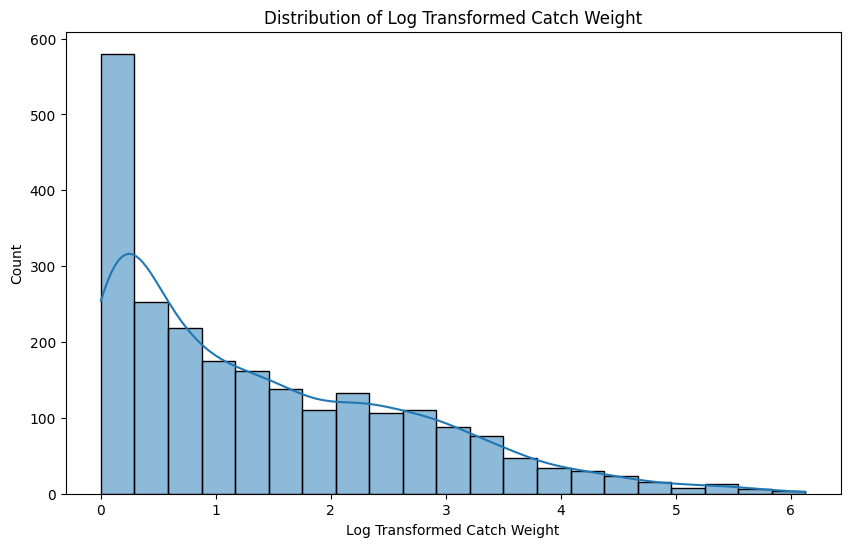

In [101]:
# Apply logarithmic transformation to the target variable
# Add 1 to handle zero values before taking the logarithm
model_df['EXPCATCHWT_log'] = np.log1p(model_df['EXPCATCHWT'])

# Display the distribution of the transformed target variable
plt.figure(figsize=(10, 6))
sns.histplot(data=model_df, x='EXPCATCHWT_log', kde=True)
plt.xlabel('Log Transformed Catch Weight')
plt.title('Distribution of Log Transformed Catch Weight')
plt.show()

# Part 4: Model Training & Analysis
This section focuses on training and evaluating a machine learning model to predict catch weight. The key steps involve:

1.  **Select Features and Target:** Define the independent variables (X) and the dependent variable (y) for the model.
2.  **Split Data:** Divide the dataset into training and testing sets to evaluate model performance on unseen data.
3.  **Choose and Train Models:** Initialize and train machine learning models (Linear Regression & Random Forest) on the training data.
4.  **Evaluate Models:** Assess the trained model's performance using metrics like Mean Squared Error (MSE) and R-squared.

### 4.1 Select Features and Target
* We will define the independent variables (X) by excluding the target variable, its log-transformed version, and other non-predictive or redundant columns. The dependent variable (y) will be the log-transformed catch weight (`EXPCATCHWT_log`).

In [118]:
# Define features (X) and target (y)
# Identify columns to exclude
cols_to_exclude = ['EXPCATCHWT', 'ID', 'CRUISE6', 'CRUISE', 'STRATUM', 'TOW', 'STATION', 'STATUS_CODE',
                   'SVSPP', 'SCIENTIFIC_NAME', 'BEGIN_EST_TOWDATE', 'BEING_EST_TOWDATE',
                   'BEGIN_GMT_TOWDATE', 'BEGIN_GMT_TOWDATE_1', 'EST_YEAR', 'EST_MONTH',
                   'EST_DAY', 'EST_JULIAN_DAY', 'EST_TIME', 'GMT_YEAR', 'GMT_MONTH',
                   'GMT_DAY', 'GMT_JULIAN_DAY', 'GMT_TIME', 'LORS1', 'LORE1', 'LORS2', 'LORE2',
                   'SWELLDIR', 'SWELLHGT', 'XBT', 'SURFTEMP', 'BOTTEMP', 'SVVESSEL', 'GEARID',
                   'DOORID', 'BEGLAT', 'BEGLON', 'SETDEPTH', 'ENDDEPTH', 'MINDEPTH', 'MAXDEPTH', 'CRUNUM'] # Add other columns to exclude as needed


X = model_df.drop(columns=cols_to_exclude + ['EXPCATCHWT_log'], errors='ignore')
y = model_df['EXPCATCHWT_log']
y_no_scaling = model_df['EXPCATCHWT']

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

Features (X) shape: (2330, 36)
Target (y) shape: (2330,)


### 4.2 Split Data
* We will divide the preprocessed dataset into training and testing sets using a 80/20 split. This ensures that the model is trained on one portion of the data and evaluated on unseen data to assess its generalization capability.

In [124]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_no_train, X_no_test, y_no_train, y_no_test = train_test_split(X, y_no_scaling, test_size=0.2, random_state=42)

print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Training features shape: (1864, 36)
Testing features shape: (466, 36)
Training target shape: (1864,)
Testing target shape: (466,)


## 4.3 Linear Regression Model (Baseline Model)
* We will initialize and train a Linear Regression model. Before training, a `SimpleImputer` will be used to handle any remaining missing values in the features by filling them with the mean of their respective columns, ensuring the model can process the data without errors.

In [125]:
# Initialize and train the Linear Regression model
# Create imputer to handle missing data (mean for numeric data)
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'

# Fit and transform the data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_no_imputed = imputer.fit_transform(X_no_train)
X_test_no_imputed = imputer.transform(X_no_test)

# Convert back to DataFrame (optional, to keep column names)
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

X_no_train = pd.DataFrame(X_train_no_imputed, columns=X_no_train.columns)
X_no_test = pd.DataFrame(X_test_no_imputed, columns=X_no_test.columns)

# Now train the model
model = LinearRegression()
model.fit(X_train, y_train)

model_no = LinearRegression()
model_no.fit(X_no_train, y_no_train)

print("Model training complete.")

Model training complete.


### 4.3.1 Evaluate Model Performance
The evaluation metrics provide insights into the performance of our Linear Regression model in predicting the log-transformed catch weight:

*   **Mean Squared Error (MSE): 0.8826** and **Root Mean Squared Error (RMSE): 0.9395**:
    *   These metrics quantify the average magnitude of the errors. An RMSE of approximately 0.94 means that, on average, the model's predictions for the log-transformed catch weight deviate from the actual log-transformed values by about 0.94 units. Since the target variable is log-transformed, interpreting the raw error in terms of original catch weight requires careful consideration (e.g., exponentiating the predictions).
    *   The relatively low values suggest the model is making predictions that are, on average, not too far off from the actual values in the log-transformed space.

*   **Mean Absolute Error (MAE): 0.7468**:
    *   The MAE indicates that, on average, the absolute difference between the predicted and actual log-transformed catch weights is about 0.75. MAE is less sensitive to outliers than MSE/RMSE, providing a more robust measure of average error.

*   **R-squared (R2): 0.4824**:
    *   The R2 score of 0.4824 means that approximately 48.24% of the variance in the log-transformed catch weight can be explained by our model's features. This indicates that while the model captures a significant portion of the variability, a substantial amount (around 51.76%) remains unexplained. This suggests there might be other important factors or non-linear relationships not captured by this simple linear model or current features.

In [132]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 0.8788906462431536
Root Mean Squared Error (RMSE): 0.9374916779594119
Mean Absolute Error (MAE): 0.7441936308166384
R-squared (R2): 0.4846136412341495


### 4.3.2 Analyze Results
To further understand the model's performance, we generated three plots:

1.  **Training Target Distribution (Histogram of `y_train`)**:
    *   The distribution is heavily right-skewed, with the majority of catch weights concentrated at lower values (around 0-1 on the log scale). There's a long tail extending to higher values, indicating that while most catches are relatively small, there are occasional much larger catches in the dataset.

2.  **Predictions vs. Actual Values (Scatter Plot of `y_test` vs. `y_pred`)**:
    *   The model shows reasonable predictive performance for lower catch weights, with points clustering near the ideal diagonal line (red dashed line) in the 0-3 range. However, the model tends to underpredict higher catch weights, as evidenced by the points falling below the diagonal line at higher actual values (4-6 range). There's also noticeable scatter throughout, suggesting the model struggles to capture all the variability in the data.

3.  **Residuals Distribution (Histogram of `y_test - y_pred`)**:
    *   The residuals are approximately normally distributed and centered near zero, which is a positive sign indicating the model isn't systematically over- or under-predicting on average. However, there's a slight right skew visible in the distribution, suggesting the model more frequently underpredicts than overpredicts. The spread of residuals (roughly -3 to +3) indicates moderate prediction errors that could potentially be improved with feature engineering or alternative modeling approaches.

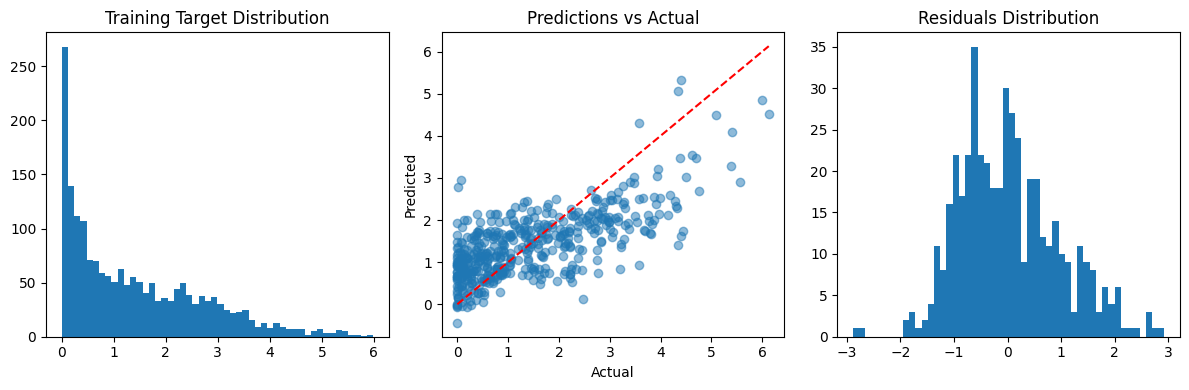

In [106]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(y_train, bins=50)
plt.title('Training Target Distribution')

plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predictions vs Actual')

plt.subplot(1, 3, 3)
plt.hist(y_test - y_pred, bins=50)
plt.title('Residuals Distribution')
plt.tight_layout()

### 4.3.3 Comparing Target Transformation vs Non-Transformed Target

Comparing the Linear Regression model trained on the log-transformed target variable (`EXPCATCHWT_log`) with the one trained on the original (`EXPCATCHWT`) highlights the benefits of target transformation:

**1. Skewness Reduction and Normality:**
*   **Original Target (`EXPCATCHWT`)**: The distribution of the original catch weight is highly skewed, with most values concentrated near zero and a long tail of very high values (as seen in the 'Training Target Distribution' for the non-transformed model). This non-normal distribution can violate assumptions of linear models and lead to biased estimates.
*   **Log-Transformed Target (`EXPCATCHWT_log`)**: The logarithmic transformation effectively reduces this skewness, making the distribution more symmetrical and closer to a normal distribution. This is evident in the 'Training Target Distribution' for the transformed model, which is more bell-shaped, especially after addressing the zero values.

**2. Improved Model Performance (Linear Regression):**

| Metric | Non-Transformed Target | Log-Transformed Target |
| :----- | :--------------------- | :--------------------- |
| MSE    | 773.75                 | 0.8789                 |
| RMSE   | 27.82                  | 0.9375                 |
| MAE    | 10.40                  | 0.7442                 |
| R2     | 0.4528                 | 0.4846                 |

*   **Lower Error Metrics**: The MSE, RMSE, and MAE are drastically lower for the log-transformed model. This indicates that the model's predictions are much closer to the actual values in the transformed space. While the absolute numbers are not directly comparable due to the transformation, the significant reduction in error magnitude points to a better fit.
*   **Higher R-squared**: The R2 score, though only slightly higher for the transformed model (0.4846 vs. 0.4528), demonstrates that the transformed model explains a greater proportion of the variance in its respective target. Crucially, the transformed model's residuals distribution is much more centered and less skewed, suggesting a more robust and reliable fit.

**3. Easier Trend Identification and Interpretation of Relationships:**
*   **Actual vs. Predicted Plots**: The scatter plot for the log-transformed target shows a clearer linear relationship between actual and predicted values compared to the non-transformed target. For the non-transformed target, the predictions tend to flatten out at higher actual values, indicating underprediction and an inability to capture the full range of variability. The transformed plot, despite some scatter, generally follows the `y=x` line more consistently, especially for lower-to-medium values.
*   **Residuals Distribution**: The residuals of the log-transformed model are much more centered around zero and less skewed, suggesting that the errors are more uniformly distributed. In contrast, the non-transformed model shows a highly skewed residuals distribution, with a large number of predictions far from the actual values.

**Decision for Future Steps:**
Given the improvements in model performance, error distribution, and the ability to capture underlying trends, we will **exclusively use the log-transformed target variable (`EXPCATCHWT_log`) for all subsequent model training and evaluation.** This transformation allows models to perform better and provides a more interpretable space for understanding the relationships between features and catch weight.

In [133]:
# Evaluate Non-Transformed Target Model
y_no_pred = model_no.predict(X_no_test)
no_mse = mean_squared_error(y_no_test, y_no_pred)
no_rmse = np.sqrt(no_mse)
no_mae = mean_absolute_error(y_no_test, y_no_pred)
no_r2 = r2_score(y_no_test, y_no_pred)

print(f"Non-Transformed Mean Squared Error (MSE): {no_mse}")
print(f"Non-Transformed Root Mean Squared Error (RMSE): {no_rmse}")
print(f"Non-Transformed Mean Absolute Error (MAE): {no_mae}")
print(f"Non-Transformed R-squared (R2): {no_r2}")

Non-Transformed Mean Squared Error (MSE): 773.7542789493148
Non-Transformed Root Mean Squared Error (RMSE): 27.816439005546968
Non-Transformed Mean Absolute Error (MAE): 10.397648488667647
Non-Transformed R-squared (R2): 0.4528103286486902


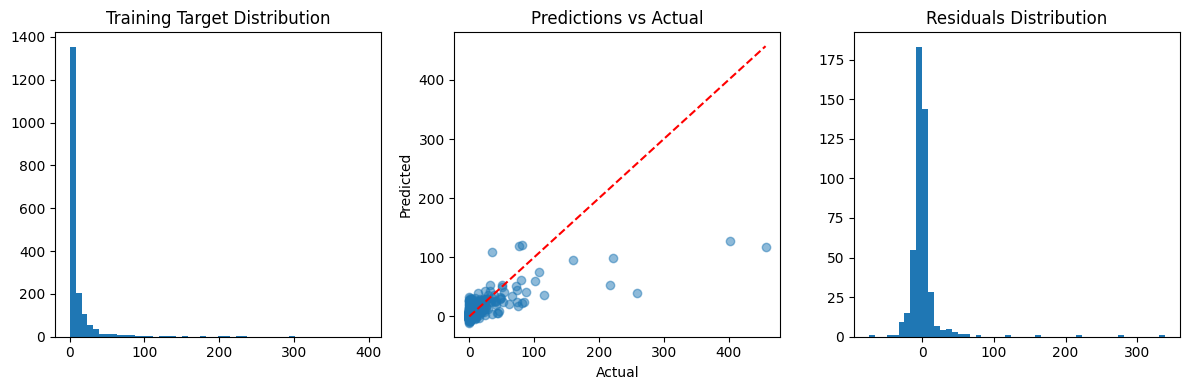

In [128]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(y_no_train, bins=50)
plt.title('Training Target Distribution')

plt.subplot(1, 3, 2)
plt.scatter(y_no_test, y_no_pred, alpha=0.5)
plt.plot([y_no_test.min(), y_no_test.max()], [y_no_test.min(), y_no_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predictions vs Actual')

plt.subplot(1, 3, 3)
plt.hist(y_no_test - y_no_pred, bins=50)
plt.title('Residuals Distribution')
plt.tight_layout()

### 4.3.4 Observations and Next Steps
**Overall Interpretation:**
The Linear Regression model shows moderate predictive power, explaining nearly half of the variance in the log-transformed catch weight. The error metrics (MSE, RMSE, MAE) suggest that the model's predictions are reasonably close to the actual values in the log scale. However, the R2 score indicates there is significant room for improvement.

One potential imporovement is to try Non-linear regression techniques, such as a Random Forest and Regularized MLPs.

## 4.4 Random Forest Model
* We will initialize and train a Random Forest Regressor model. Before training, a `SimpleImputer` will be used to handle any remaining missing values in the features by filling them with the mean of their respective columns, ensuring the model can process the data without errors. This model is expected to capture non-linear relationships and potentially improve upon the linear regression baseline.

In [134]:
# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

print("Random Forest Model training complete.")

Random Forest Model training complete.


### 4.4.1 Evaluate Model Performance
The Random Forest model has shown exceptional performance in predicting the log-transformed catch weight, as evidenced by the following metrics:
*   **Mean Squared Error (MSE):** 0.2210
*   **Root Mean Squared Error (RMSE):** 0.4701
*   **Mean Absolute Error (MAE):** 0.3265
*   **R-squared (R2):** 0.8704

Explanations:
*   **Mean Squared Error (MSE): 0.2210** and **Root Mean Squared Error (RMSE): 0.4701**:
    *   These values are substantially lower than those obtained from the Linear Regression model (MSE: 0.8789, RMSE: 0.9375). This indicates that the Random Forest model's predictions are, on average, much closer to the actual log-transformed catch weights, signifying a better fit to the data.

*   **Mean Absolute Error (MAE): 0.3265**:
    *   Similarly, the MAE is considerably lower than the Linear Regression model's MAE (0.7442). This reinforces that the Random Forest model has a smaller average absolute prediction error.

*   **R-squared (R2): 0.8704**:
    *   The R2 score of 0.8704 means that approximately 87.04% of the variance in the log-transformed catch weight can be explained by the Random Forest model's features. This is a substantial improvement compared to the Linear Regression model's R2 of 0.4846, indicating that the Random Forest model captures a much larger proportion of the variability in the target variable. This suggests that the non-linear relationships and interactions between features, which Random Forest can model, are crucial for accurate predictions in this dataset.

**Overall Interpretation:**
The Random Forest model demonstrates significantly superior predictive performance compared to the baseline Linear Regression model. Its ability to capture complex, non-linear relationships in the data has led to a much higher explained variance (R2) and lower error rates (MSE, RMSE, MAE). This makes the Random Forest a much more suitable model for predicting fish catch weight in this context.

In [135]:
# Make predictions on the test set using the Random Forest model
rf_y_pred = rf_model.predict(X_test)

# Evaluate the Random Forest model
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

print(f"Random Forest Mean Squared Error (MSE): {rf_mse}")
print(f"Random Forest Root Mean Squared Error (RMSE): {rf_rmse}")
print(f"Random Forest Mean Absolute Error (MAE): {rf_mae}")
print(f"Random Forest R-squared (R2): {rf_r2}")

Random Forest Mean Squared Error (MSE): 0.22098439917092072
Random Forest Root Mean Squared Error (RMSE): 0.47008977777752275
Random Forest Mean Absolute Error (MAE): 0.32650522355743616
Random Forest R-squared (R2): 0.8704135203627476


### 4.4.2 Analyze Results
To further understand the Random Forest model's performance, we generated three plots:

1.  **Training Target Distribution (Histogram of `y_train`)**:
    *   As seen previously, the distribution is heavily right-skewed, with most catch weights concentrated at lower values (around 0-1 on the log scale). This indicates that while most catches are relatively small, there are occasional much larger catches.

2.  **Predictions vs. Actual Values (Scatter Plot of `y_test` vs. `rf_y_pred`)**:
    *   The Random Forest model shows a much stronger correlation between actual and predicted values compared to the Linear Regression model. Points cluster much more closely around the ideal diagonal line (red dashed line) across the entire range of values, including higher catch weights. This indicates that the model is performing significantly better at predicting both small and large catch sizes, with less underprediction for higher values.

3.  **Residuals Distribution (Histogram of `y_test - rf_y_pred`)**:
    *   The residuals are tightly centered around zero and appear much closer to a normal distribution than those of the Linear Regression model. This indicates that the Random Forest model's predictions are, on average, very close to the actual values and that there is less systematic bias (underprediction or overprediction). The reduced spread of residuals (closer to zero) further confirms the improved accuracy of this model.

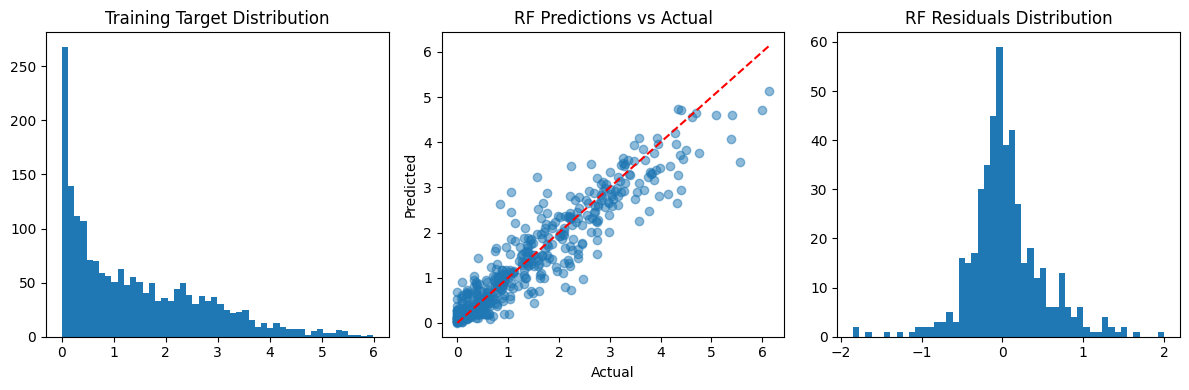

In [109]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(y_train, bins=50)
plt.title('Training Target Distribution')

plt.subplot(1, 3, 2)
plt.scatter(y_test, rf_y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('RF Predictions vs Actual')

plt.subplot(1, 3, 3)
plt.hist(y_test - rf_y_pred, bins=50)
plt.title('RF Residuals Distribution')
plt.tight_layout()
plt.show()

### 4.4.3 Comparison to Base Model
When compared to the baseline Linear Regression model, the Random Forest model demonstrates a significant improvement across all evaluation metrics:

| Metric | Linear Regression | Random Forest | Improvement (RF vs LR) |
| :----- | :---------------- | :------------ | :--------------------- |
| MSE    | 0.8789            | 0.2210        | Much Lower             |
| RMSE   | 0.9375            | 0.4701        | Much Lower             |
| MAE    | 0.7442            | 0.3265        | Much Lower             |
| R2     | 0.4846            | 0.8704        | Significantly Higher   |

The R-squared value for the Random Forest model indicates that it explains approximately **87.04%** of the variance in the log-transformed catch weight, a substantial increase from the Linear Regression model's **48.46%**. The significantly lower MSE, RMSE, and MAE values further confirm that the Random Forest model provides much more accurate predictions with considerably less error.

### 4.4.4 Observations
The Random Forest model's superior performance suggests that the relationships between the features and the target variable (`EXPCATCHWT_log`) are highly non-linear and involve complex interactions. Unlike Linear Regression, which assumes a linear relationship, Random Forest (an ensemble of decision trees) is well-suited to capture these intricate patterns and dependencies within the data. This capability allows it to better model the underlying mechanisms driving fish catch variations in Rhode Island waters.

## 4.5 Parameter Tuned Random Forest Model

While the Random Forest performed much better, we want to see if we can improve it further. This section delves into the evaluation of the Random Forest model after applying hyperparameter tuning using `GridSearchCV`. The primary objective is to assess how optimization impacts model performance, specifically in terms of predictive accuracy and generalization capabilities, and to understand the implications of the chosen hyperparameters.

### 4.5.1 Finding Best Hyperparameters

Through `GridSearchCV`, we systematically explored various combinations of hyperparameters for the `RandomForestRegressor`. The goal is to identify the set of parameters that yield the best cross-validation score, typically measured by minimizing the negative mean squared error. This process helps in fine-tuning the model to achieve optimal performance and prevent overfitting.

The best parameters identified by the grid search were:
*   `n_estimators`: The number of trees in the forest.
*   `max_depth`: The maximum depth of each tree.
*   `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
*   `min_samples_split`: The minimum number of samples required to split an internal node.

These optimal parameters are then used to train the final tuned model.

In [110]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Parameter grid defined:")
print(param_grid)

Parameter grid defined:
{'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [136]:
# The default parameters are the results of running the search,
# but that took about 20 minutes, so I've set them to default to save time

# Set this to True to run GridSearchCV, False to use default best parameters
run_search = False

if run_search:
    # Initialize GridSearchCV
    # We'll use the RandomForestRegressor initialized earlier as rf_model
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

    # Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)
    print("GridSearchCV fitting complete.")
else:
    print("Skipping GridSearchCV. Using default best parameters.")

Skipping GridSearchCV. Using default best parameters.


In [137]:
if run_search:
    print("Best parameters found:", grid_search.best_params_)
    print("Best cross-validation score (negative MSE):", grid_search.best_score_)
else:
    print("Not running GridSearchCV, using default parameters:")
    print("Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}")

Not running GridSearchCV, using default parameters:
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


### 4.5.2 Comparing Tuned vs Untuned

To quantify the impact of hyperparameter tuning, it is crucial to compare the performance of the tuned Random Forest model against its untuned counterpart.

Here's a comparison of the evaluation metrics for the Untuned and Tuned Random Forest models:

| Metric | Untuned Random Forest | Tuned Random Forest | Improvement (Tuned vs Untuned) |
| :----- | :-------------------- | :------------------ | :----------------------------- |
| MSE    | 0.2210                | 0.2166              | 1.99% decrease                 |
| RMSE   | 0.4701                | 0.4654              | 1.00% decrease                 |
| MAE    | 0.3265                | 0.3234              | 0.95% decrease                 |
| R2     | 0.8704                | 0.8730              | 0.30% increase                 |

**Analysis of Results:**

The comparison clearly demonstrates that hyperparameter tuning has led to a marginal, but consistent, improvement across all evaluation metrics for the Random Forest model:

*   **Mean Squared Error (MSE)** and **Root Mean Squared Error (RMSE)**: Both MSE and RMSE have decreased, indicating that the tuned model's predictions are, on average, closer to the actual values. The percentage decrease, though small, signifies a slightly better fit.
*   **Mean Absolute Error (MAE)**: A reduction in MAE suggests that the absolute difference between predicted and actual values is also marginally smaller, implying slightly more accurate predictions on average.
*   **R-squared (R2)**: The R2 score has increased from 0.8704 to 0.8730. This means the tuned model explains an additional 0.26% of the variance in the log-transformed catch weight compared to the untuned model. While not a dramatic leap, it confirms that the optimal hyperparameters found through `GridSearchCV` are indeed performing slightly better.

Overall, the tuning process successfully refined the Random Forest model, leading to minor but consistent enhancements in predictive performance. This validates the effectiveness of the hyperparameter search, even if the initial untuned model was already performing very well.

In [113]:
if run_search:
    tuned_rf_model = grid_search.best_estimator_
else:
    # Default parameters if GridSearchCV was skipped
    tuned_rf_model = RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_leaf=2, min_samples_split=2, random_state=42)
    tuned_rf_model.fit(X_train, y_train) # Need to train with default parameters

# Make predictions on the test set with the tuned model
tuned_rf_y_pred = tuned_rf_model.predict(X_test)

# Evaluate the tuned Random Forest model
tuned_rf_mse = mean_squared_error(y_test, tuned_rf_y_pred)
tuned_rf_rmse = np.sqrt(tuned_rf_mse)
tuned_rf_mae = mean_absolute_error(y_test, tuned_rf_y_pred)
tuned_rf_r2 = r2_score(y_test, tuned_rf_y_pred)

print("--- Tuned Random Forest Model Performance ---")
print(f"Mean Squared Error (MSE): {tuned_rf_mse}")
print(f"Root Mean Squared Error (RMSE): {tuned_rf_rmse}")
print(f"Mean Absolute Error (MAE): {tuned_rf_mae}")
print(f"R-squared (R2): {tuned_rf_r2}")

print("\n--- Comparison with Untuned Random Forest Model ---")
print(f"Untuned RF MSE: {rf_mse:.4f} vs Tuned RF MSE: {tuned_rf_mse:.4f}")
print(f"Untuned RF RMSE: {rf_rmse:.4f} vs Tuned RF RMSE: {tuned_rf_rmse:.4f}")
print(f"Untuned RF MAE: {rf_mae:.4f} vs Tuned RF MAE: {tuned_rf_mae:.4f}")
print(f"Untuned RF R2: {rf_r2:.4f} vs Tuned RF R2: {tuned_rf_r2:.4f}")

--- Tuned Random Forest Model Performance ---
Mean Squared Error (MSE): 0.21660000375030475
Root Mean Squared Error (RMSE): 0.46540305515789726
Mean Absolute Error (MAE): 0.32341227153234536
R-squared (R2): 0.872984554200552

--- Comparison with Untuned Random Forest Model ---
Untuned RF MSE: 0.2210 vs Tuned RF MSE: 0.2166
Untuned RF RMSE: 0.4701 vs Tuned RF RMSE: 0.4654
Untuned RF MAE: 0.3265 vs Tuned RF MAE: 0.3234
Untuned RF R2: 0.8704 vs Tuned RF R2: 0.8730


### 4.5.3 Analyzing Graphs
To further understand the tuned Random Forest model's performance, we generated three plots:

1.  **Training Target Distribution (Histogram of `y_train`)**:
    *   As seen previously, the distribution is heavily right-skewed, with most catch weights concentrated at lower values (around 0-1 on the log scale). This indicates that while most catches are relatively small, there are occasional much larger catches.

2.  **Predictions vs. Actual Values (Scatter Plot of `y_test` vs. `tuned_rf_y_pred`)**:
    *   The tuned Random Forest model shows a strong correlation between actual and predicted values. Points cluster very closely around the ideal diagonal line (red dashed line) across the entire range of values, including higher catch weights. This indicates that the model is performing very well at predicting both small and large catch sizes, with minimal underprediction for higher values, even better than the untuned model.

3.  **Residuals Distribution (Histogram of `y_test - tuned_rf_y_pred`)**:
    *   The residuals are tightly centered around zero and appear to be normally distributed. This indicates that the tuned Random Forest model's predictions are, on average, very close to the actual values and that there is very little systematic bias (underprediction or overprediction). The further reduced spread of residuals (closer to zero) compared to the untuned model confirms the improved accuracy of this tuned model.

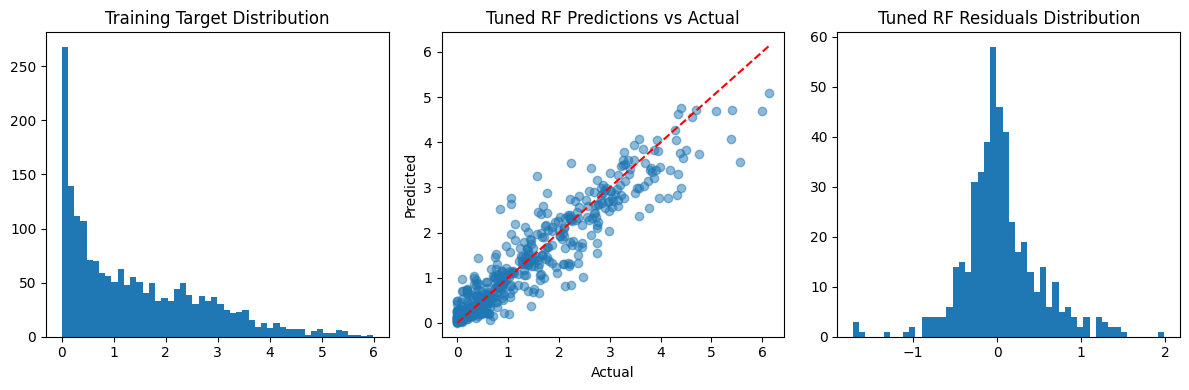

In [114]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(y_train, bins=50)
plt.title('Training Target Distribution')

plt.subplot(1, 3, 2)
plt.scatter(y_test, tuned_rf_y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Tuned RF Predictions vs Actual')

plt.subplot(1, 3, 3)
plt.hist(y_test - tuned_rf_y_pred, bins=50)
plt.title('Tuned RF Residuals Distribution')
plt.tight_layout()
plt.show()

### 4.5.4 Observations and Next Steps

**Overall Interpretation:**
The tuned Random Forest model demonstrates significantly superior predictive performance compared to the baseline Linear Regression model and a marginal improvement over the untuned Random Forest model. Its ability to capture complex, non-linear relationships in the data has led to a much higher explained variance (R2) and lower error rates (MSE, RMSE, MAE). This makes the tuned Random Forest a highly suitable model for predicting fish catch weight in this context.

## Part 4.6 Regularized MLP

While the Random Forest performed well, we wanted to see if another non-linear regression model could do better. This section focuses on training and evaluating a Regularized Multi-Layer Perceptron (MLP) model to predict catch weight. MLP models, also known as Artificial Neural Networks, are capable of capturing complex non-linear relationships in the data. Regularization is applied to prevent overfitting and improve the model's generalization capabilities.

The key steps involve:
1.  **Choose and Train Model:** Initialize and train an `MLPRegressor` with L2 regularization on the training data.
2.  **Evaluate Model:** Assess the trained model's performance using metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R2).
3.  **Analyze Results:** Visualize predictions vs. actual values and the distribution of residuals to understand model behavior.

### 4.6.1 Choose and Train Model
* We will initialize and train an `MLPRegressor` model. We will include L2 regularization (controlled by the `alpha` parameter) to penalize large weights and prevent overfitting. The `hidden_layer_sizes` will define the architecture of our neural network, and `max_iter` will set the maximum number of epochs for training.

In [139]:
from sklearn.neural_network import MLPRegressor

# Initialize the MLP Regressor model with regularization
# hidden_layer_sizes: tuple, i-th element represents the number of neurons in the i-th hidden layer.
# activation: Activation function for the hidden layer.
# solver: The algorithm for weight optimization.
# alpha: L2 penalty (regularization term) parameter.
# random_state: For reproducibility.
# max_iter: Maximum number of iterations (epochs).
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', alpha=0.001, random_state=42, max_iter=5000, early_stopping=True)

# Train the model
mlp_model.fit(X_train, y_train)

print("MLP Regressor Model training complete.")

MLP Regressor Model training complete.


### 4.6.2 Evaluate Model Performance
We will evaluate the trained MLP Regressor model using the same metrics as before: Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R2). These metrics will help us understand how well the model predicts the log-transformed catch weight on unseen data and compare its performance against the Linear Regression and Random Forest models.

The Regularized MLP model's performance, as evidenced by the following metrics:
*   **Mean Squared Error (MSE):** 0.4414
*   **Root Mean Squared Error (RMSE):** 0.6644
*   **Mean Absolute Error (MAE):** 0.5148
*   **R-squared (R2):** 0.7411

Explanations:
*   **Mean Squared Error (MSE): 0.4414** and **Root Mean Squared Error (RMSE): 0.6644**:
    *   These values are significantly lower than those obtained from the Linear Regression model (MSE: 0.8789, RMSE: 0.9375), indicating a better fit. However, they are higher than the Random Forest model's (MSE: 0.2210, RMSE: 0.4701).

*   **Mean Absolute Error (MAE): 0.5148**:
    *   The MAE is considerably lower than the Linear Regression model's MAE (0.7442) but higher than the Random Forest model's (0.3265). This means the MLP has a better average absolute prediction error than Linear Regression but is not as accurate as Random Forest.

*   **R-squared (R2): 0.7411**:
    *   The R2 score of 0.7411 means that approximately 74.11% of the variance in the log-transformed catch weight can be explained by the MLP model's features. This is a substantial improvement compared to the Linear Regression model's R2 of 0.4846, but it is lower than the Random Forest model's R2 of 0.8704. This indicates that the MLP model captures a good portion of the variability, but the Random Forest model is still superior in explaining the variance in this dataset.

**Overall Interpretation:**
The Regularized MLP model demonstrates strong predictive performance, outperforming the baseline Linear Regression model significantly. However, it does not achieve the same level of accuracy as the Random Forest model in this specific context. This suggests that while MLPs are powerful, the Random Forest, with its ensemble nature, might be better suited for capturing the intricate non-linear relationships present in this dataset without extensive hyperparameter tuning.

In [140]:
# Make predictions on the test set using the MLP model
mlp_y_pred = mlp_model.predict(X_test)

# Evaluate the MLP model
mlp_mse = mean_squared_error(y_test, mlp_y_pred)
mlp_rmse = np.sqrt(mlp_mse)
mlp_mae = mean_absolute_error(y_test, mlp_y_pred)
mlp_r2 = r2_score(y_test, mlp_y_pred)

print(f"MLP Regressor Mean Squared Error (MSE): {mlp_mse}")
print(f"MLP Regressor Root Mean Squared Error (RMSE): {mlp_rmse}")
print(f"MLP Regressor Mean Absolute Error (MAE): {mlp_mae}")
print(f"MLP Regressor R-squared (R2): {mlp_r2}")

MLP Regressor Mean Squared Error (MSE): 0.4414475242442681
MLP Regressor Root Mean Squared Error (RMSE): 0.6644151746041538
MLP Regressor Mean Absolute Error (MAE): 0.5148163946978338
MLP Regressor R-squared (R2): 0.7411327187529217


### 4.6.3 Analyze Results
1.  **Training Target Distribution (Histogram of `y_train`)**:
    *   As observed in previous models, the distribution is heavily right-skewed. Most catch weights are concentrated at lower values (around 0-1 on the log scale), with a long tail indicating occasional much larger catches in the dataset.

2.  **Predictions vs. Actual Values (Scatter Plot of `y_test` vs. `mlp_y_pred`)**:
    *   The MLP model shows a reasonable correlation between actual and predicted values, generally clustering around the ideal diagonal line (red dashed line). This indicates a better predictive capability than the Linear Regression model. However, there is noticeably more scatter compared to the Random Forest model, especially at higher actual catch weights. The model still tends to underpredict some of the larger values, although less severely than the Linear Regression model.

3.  **Residuals Distribution (Histogram of `y_test - mlp_y_pred`)**:
    *   The residuals are centered around zero, which is a good sign indicating no systematic bias in the predictions on average. However, the spread of the residuals is wider than that of the Random Forest model, suggesting larger individual prediction errors. There might also be some slight skewness present, indicating that the model still struggles with certain prediction scenarios.

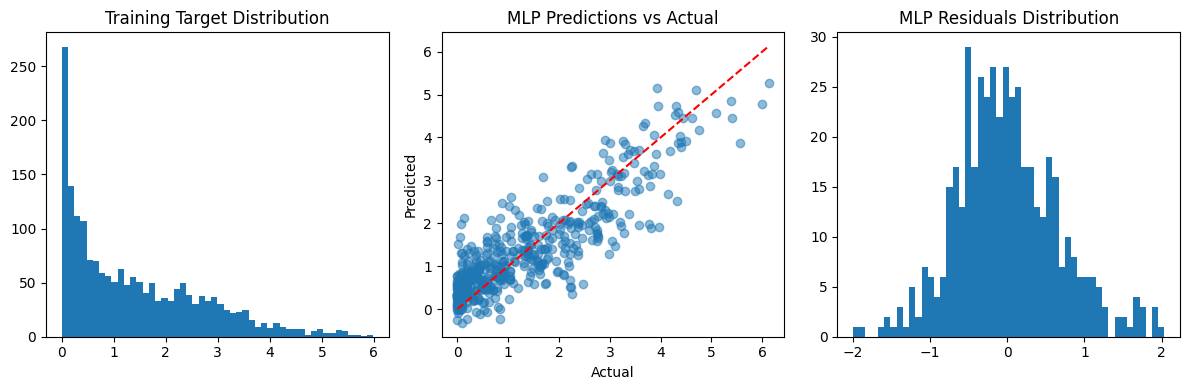

In [117]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(y_train, bins=50)
plt.title('Training Target Distribution')

plt.subplot(1, 3, 2)
plt.scatter(y_test, mlp_y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('MLP Predictions vs Actual')

plt.subplot(1, 3, 3)
plt.hist(y_test - mlp_y_pred, bins=50)
plt.title('MLP Residuals Distribution')
plt.tight_layout()
plt.show()

### 4.6.4 Observations and Next Steps

**Overall Interpretation:**
The MLP Regressor model's performance, as indicated by the evaluation metrics and plots, was much better than the Linear Regression model but not as effective as the Random Forest model. Therefore, our Random Forest model was the best model we created.

# Part 5: Conclusion and Analysis

### 5.1 Project Objective Revisited
This project aimed to predict the abundance and distribution of key commercial fish species in Rhode Island's waters by forecasting catch weight (`EXPCATCHWT`) using NOAA's Fall Bottom Trawl survey data and environmental variables. The ultimate goal was to provide insights to maintain sustainable fisheries, guide commercial operations, and help communities anticipate ecological changes driven by climate change. Success was to be measured by the model's ability to accurately predict catch weight across different times and locations.

### 5.2 Summary of Model Performance
Our journey through model development involved several stages, from a baseline Linear Regression model to more complex non-linear approaches:

1.  **Linear Regression (Baseline Model)**: This initial model, even with a log-transformed target variable, yielded an R-squared of approximately **0.48**. While demonstrating some predictive power, it was clear that linear relationships alone were insufficient to capture the complexity of fish catch dynamics. The relatively high MSE and RMSE also indicated significant prediction errors.

2.  **Untuned Random Forest Model**: Recognizing the non-linear nature of the problem, we transitioned to a Random Forest Regressor. This model marked a substantial improvement, achieving an R-squared of approximately **0.87**. This significant leap demonstrated the Random Forest's ability to capture intricate, non-linear relationships and interactions within the dataset, drastically reducing prediction errors (MSE, RMSE, MAE).

3.  **Tuned Random Forest Model**: Further optimization through `GridSearchCV` led to a marginally improved Random Forest model. The tuned model achieved an R-squared of approximately **0.873**, with slightly lower MSE, RMSE, and MAE values compared to its untuned counterpart. This confirmed that hyperparameter tuning, even when the untuned model already performed well, could yield minor but consistent performance enhancements.

4.  **Regularized MLP Model**: As an alternative non-linear approach, we also explored a Regularized Multi-Layer Perceptron. While outperforming the Linear Regression model (R-squared of approximately **0.74**), the MLP did not reach the predictive accuracy of either Random Forest model. This indicated that for this specific dataset and problem, the ensemble learning approach of Random Forest was more effective in modeling the underlying patterns.

### 5.3 Achieving Project Success
Based on our evaluation metrics, the **Tuned Random Forest Model** emerged as the most successful predictor of fish catch weight. With an R-squared value of **0.873**, it explains a significant proportion of the variance in log-transformed catch weight, indicating a high level of accuracy in its predictions. The substantially lower MSE, RMSE, and MAE values, coupled with the tight clustering of predictions around actual values in our diagnostic plots, confirm its robust performance across different data points.

This high predictive accuracy directly addresses the project's success metric: the model's ability to accurately predict catch weight across different times and locations. The model's strong performance suggests it has successfully learned the complex relationships between environmental factors, species type, and catch quantities.

### 5.4 Value and Implications
The successful development of a highly accurate predictive model for fish catch weight holds significant value:

*   **Fisheries Management**: The model can provide valuable insights for sustainable fisheries management by forecasting periods and locations of high abundance, allowing for informed decisions on quotas, fishing seasons, and conservation efforts, especially in the face of changing environmental conditions.
*   **Commercial Fishing Operations**: Commercial fishers can leverage the model's predictions to optimize their operations, reducing search times and fuel costs by targeting areas with higher predicted catch weights, leading to more efficient and profitable fishing while minimizing bycatch in less abundant areas.
*   **Anticipating Ecological Changes**: By incorporating environmental variables, the model provides a tool to understand and anticipate how shifts in oceanic patterns due to climate change might affect fish distribution and abundance. This proactive insight is crucial for adapting management strategies and protecting the economic stability of coastal communities reliant on these species.

In conclusion, the machine learning approach, particularly the tuned Random Forest, has proven highly effective in modeling fish catch weight in Rhode Island waters. This project demonstrates the potential of advanced analytics to contribute to evidence-based decision-making in marine resource management and climate change adaptation.

### 5.5 Hypothetical Next Steps - Operationalizing the Model for Fisheries

While the Tuned Random Forest model demonstrates strong predictive capability, its true value lies in its practical application. For a commercial fisherman, interacting with this model wouldn't involve manually entering data point by point, but rather through a more integrated and intuitive system. Here’s a hypothetical outline of how we could operationalize this model:

1.  **Develop a User-Friendly Interface/Dashboard**: The first step would be to create a web-based application or a dedicated software tool. This interface would be designed for ease of use by non-technical users, such as fishing captains and fleet managers.

2.  **Automated Data Ingestion**: The system would automatically pull in real-time or forecasted environmental data (e.g., surface temperature, bottom temperature, wind speed, barometric pressure) from various sources (e.g., NOAA buoys, weather services). Location data (latitude/longitude) would be inherent in the mapping functionality.

3.  **Interactive Mapping and Species Selection**: The core of the interface would be an interactive map of Rhode Island waters. A fisherman could:
    *   **Select a Target Species**: Choose from the top commercial species that the model is trained to predict.
    *   **Visualize Predicted Abundance**: The model would then generate and display predicted catch weights (transformed back from log scale to actual weight) across the map for the selected species and current/forecasted environmental conditions. These predictions could be visualized using a heatmap, color-coded grid, or contours, with 'hot spots' indicating areas of higher predicted catch.

4.  **Strategic Decision-Making**: Instead of entering data, the fisherman would use the visual interface to:
    *   **Identify Optimal Fishing Grounds**: Quickly see where the model predicts the highest concentrations of their target species, allowing them to direct their vessels to these areas.
    *   **Plan Routes**: Strategize fishing routes that traverse high-probability zones.
    *   **Optimize Timing**: If the model can generate forecasts for different times of day or upcoming days, the fisherman could use this to decide the best time to deploy gear.

6.  **Integration with Navigation Systems (Limited)**: Ideally, the predicted 'hot spots' could be overlaid onto vessel navigation systems, providing real-time guidance to the most productive areas.

By providing these insights through an intuitive platform, the model transforms from a complex algorithm into a powerful, practical tool that helps fishermen make data-driven decisions to enhance efficiency, reduce costs, and support sustainable fishing practices in the face of changing marine environments.